# Backtesting Sector Strategy

### MGMT 638: Data-Driven Investments: Equity
### Kerry Back, Rice University

<a target="_blank" href="https://colab.research.google.com/github/kerryback/mgmt638/blob/main/notebooks/11-backtest_sector.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Read data

- Penny stocks have been eliminated
- Data includes both large caps and small caps.  You can filter to small caps if you want.
- Filter to your sector.

In [1]:
import pandas as pd

url = "https://www.dropbox.com/s/lm4v48d51g64l0f/data-2023-11-29.csv?dl=1"
df = pd.read_csv(url)

In [2]:
# uncomment and execute the following to filter to small caps

"""    
df["rnk"] = df.groupby("date", group_keys=False).marketcap.rank(
    ascending=False, 
    method="first"
)
df = df[(df.rnk>1000) & (df.rnk<=3000)]
df = df.drop(columns=["rnk"])
"""

'    \ndf["rnk"] = df.groupby("date", group_keys=False).marketcap.rank(\n    ascending=False, \n    method="first"\n)\ndf = df[(df.rnk>1000) & (df.rnk<=3000)]\ndf = df.drop(columns=["rnk"])\n'

### Select a sector

In [3]:
sector = "Healthcare"
df = df[df.sector==sector]

## Define model and target

- Current code uses max_depth=4 and n_estimators=200
- Two possible targets: return in excess of the median or rank of the return.
- Comment one of them out.

In [4]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_depth=4, n_estimators=200)


df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100 * (x-x.median())
)

""" 
# could use this instead

df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100 * x.rank(pct=True)
)
"""



' \n# could use this instead\n\ndf["target"] = df.groupby("date", group_keys=False).ret.apply(\n    lambda x: 100 * x.rank(pct=True)\n)\n'

## Define predictors (features)

- Leaving out interactions with market volatility, because they didn't seem to make much difference.

In [5]:
features = [
    "marketcap", 
    "pb", 
    "mom", 
    "volume", 
    "volatility", 
    "roe", 
    "accruals",
    "agr"
]
features.sort()

## Define training dates and training windows

- Start training once we have three years of data.
- Specify num_years_for_training $\ge 3$ as the number of years of past data to train on in each iteration of the backtesting loop.

In [6]:
num_years_for_training = 5

In [7]:
dates = list(df.date.unique())
dates.sort()
train_dates = dates[156::52]  # once per year starting after three years

past_dates = {}               # dates on which to train for each training date
future_dates = {}             # dates for which to predict for each training date
for date in train_dates:
    start_index = dates.index(date) - 52*num_years_for_training
    start_index = start_index if start_index >= 0 else 0
    past_dates[date] = dates[start_index:dates.index(date)]
    if date < train_dates[-1]:
        future_dates[date] = dates[dates.index(date):(dates.index(date)+52)]
    else:
        future_dates[date] = dates[dates.index(date):]

## Run the loop

In [8]:
new_data = None
for date in train_dates:
    past = past_dates[date]
    past = df[df.date.isin(past)]
    future = future_dates[date]
    future = df[df.date.isin(future)]
    forest.fit(X=past[features], y=past.target)
    predictions = forest.predict(X=future[features])
    predictions = pd.DataFrame(predictions)
    predictions.columns = ["predict"]
    for col in ["ticker", "date"]:
        predictions[col] = future[col].to_list()
    new_data = pd.concat((new_data, predictions))
    
df = df.merge(new_data, on=["ticker", "date"], how="inner")

## Calculate portfolio returns

- Specify how many stocks you want to hold in each (long or short) portfolio

In [10]:
numstocks = 50

In [11]:
df["rnk_long"] = df.groupby("date", group_keys=False).predict.rank(
    ascending=False,
    method="first"
)
df["rnk_short"] = df.groupby("date", group_keys=False).predict.rank(
    ascending=True,
    method="first"
)


longs = df[df.rnk_long<=numstocks]
shorts = df[df.rnk_short<=numstocks]

In [12]:
long_ret = longs.groupby("date").ret.mean()
short_ret = shorts.groupby("date").ret.mean()
print(f"mean annualized long return is {52*long_ret.mean():.2%}")
print(f"mean annualized short return is {52*short_ret.mean():.2%}")

mean annualized long return is 24.74%
mean annualized short return is -25.62%


## Evaluate long returns

### Get weekly factors and risk-free rate

- There is some weekly data on French's website, but not everything we want is available weekly.
- So, we will get daily data and compound to weekly.

In [13]:
from pandas_datareader import DataReader as pdr 

famafrench = pdr("F-F_Research_Data_5_Factors_2x3_daily", "famafrench", start=2010)[0] / 100  
famafrench.index.name = "date"
famafrench = famafrench.reset_index()
famafrench["year"] = famafrench.date.apply(lambda x: x.isocalendar()[0])
famafrench["week"] = famafrench.date.apply(lambda x: x.isocalendar()[1])

ff = None
for col in ["Mkt-RF", "SMB", "HML", "CMA", "RMW", "RF"]:
    ser = famafrench.groupby(["year", "week"], group_keys=True)[col].apply(
        lambda x: (1+x).prod() - 1
    )
    ser.name = col
    ff = pd.concat((ff, ser), axis=1)
ff["date"] = famafrench.groupby(["year", "week"], group_keys=True).date.last()
ff = ff.reset_index(drop=True)
ff = ff.set_index("date")

In [20]:
mom = pdr("F-F_Momentum_Factor_daily", "famafrench", start=2010)[0]/100
mom.index.name = "date"
mom.columns = ["UMD"]
mom = mom.reset_index()
mom["year"] = mom.date.apply(lambda x: x.isocalendar()[0])
mom["week"] = mom.date.apply(lambda x: x.isocalendar()[1])

umd = mom.groupby(["year", "week"], group_keys=True).UMD.apply(
    lambda x: (1+x).prod() - 1
)
umd = pd.DataFrame(umd)
umd["date"] = mom.groupby(["year", "week"], group_keys=True).date.last()
umd = umd.reset_index(drop=True)
umd = umd.set_index("date")

### Combine factors and long returns

In [28]:
long_ret.name = "ret"
long_ret.index = pd.to_datetime(long_ret.index)
data = pd.concat((ff, umd, long_ret), axis=1).dropna()
data.head(3)

,Mkt-RF,SMB,HML,CMA,RMW,RF,UMD,ret
date,,,,,,,,
2014-01-10,0.006690,0.003776,-0.014450,-0.009374,-0.016990,0.0,0.016774,0.016430
2014-01-17,-0.001175,0.004805,-0.006908,-0.001320,-0.007482,0.0,-0.003429,0.101568
2014-01-24,-0.025944,0.004589,-0.001517,-0.005691,0.000292,0.0,-0.012687,0.053994


### Sharpe ratio

In [30]:
import numpy as np

sharpe = np.sqrt(52) * (data.ret - data.RF).mean() / data.ret.std()
print(f"annualized Sharpe ratio is {sharpe:.2%}")

annualized Sharpe ratio is 71.08%


### Market alpha and information ratio

In [31]:
import statsmodels.formula.api as smf

data["ret_rf"] = data.ret - data.RF
data["mkt_rf"] = data["Mkt-RF"]
result = smf.ols("ret_rf ~ mkt_rf", data).fit()

alpha = 52*result.params["Intercept"]
resid_stdev = np.sqrt(52 * result.mse_resid)
info_ratio = alpha / resid_stdev

print(f"annualized alpha is {alpha:.2%}")
print(f"annualized information ratio is {info_ratio:.2%}")

annualized alpha is 18.65%
annualized information ratio is 56.31%


### Attribution analysis

In [32]:
result = smf.ols("ret_rf ~ mkt_rf + SMB + HML + CMA + RMW + UMD", data).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ret_rf   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     14.93
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           9.78e-16
Time:                        12:52:13   Log-Likelihood:                 866.84
No. Observations:                 508   AIC:                            -1720.
Df Residuals:                     501   BIC:                            -1690.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0043      0.002      2.181      0.030       0.000       0.008
mkt_rf         0.4520      0.089      5.065      0.000       0.277       0.627
SMB            0.4939      0.166      2.974      0.003       0.168       0.820
HML           -0.5072      0.152     -3.330      0.001      -0.806      -0.208
CMA            0.6061      0.275      2.201      0.028       0.065       1.147
RMW           -0.5944      0.204     -2.911      0.004      -0.995      -0.193
UMD           -0.2266      0.098     -2.300      0.022      -0.420      -0.033
==============================================================================
Omnibus:                       32.347   Durbin-Watson:                   2.205
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.038
Skew:                          -0.056   Prob(JB):                     3.85e-26
Kurtosis:                       5.349   Cond. No.                         153.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Analyze fitted model on most recent data

### Get most recent data from backtest data

In [39]:
present = future[future.date==future.date.max()]

### Visualize distributions of characteristics

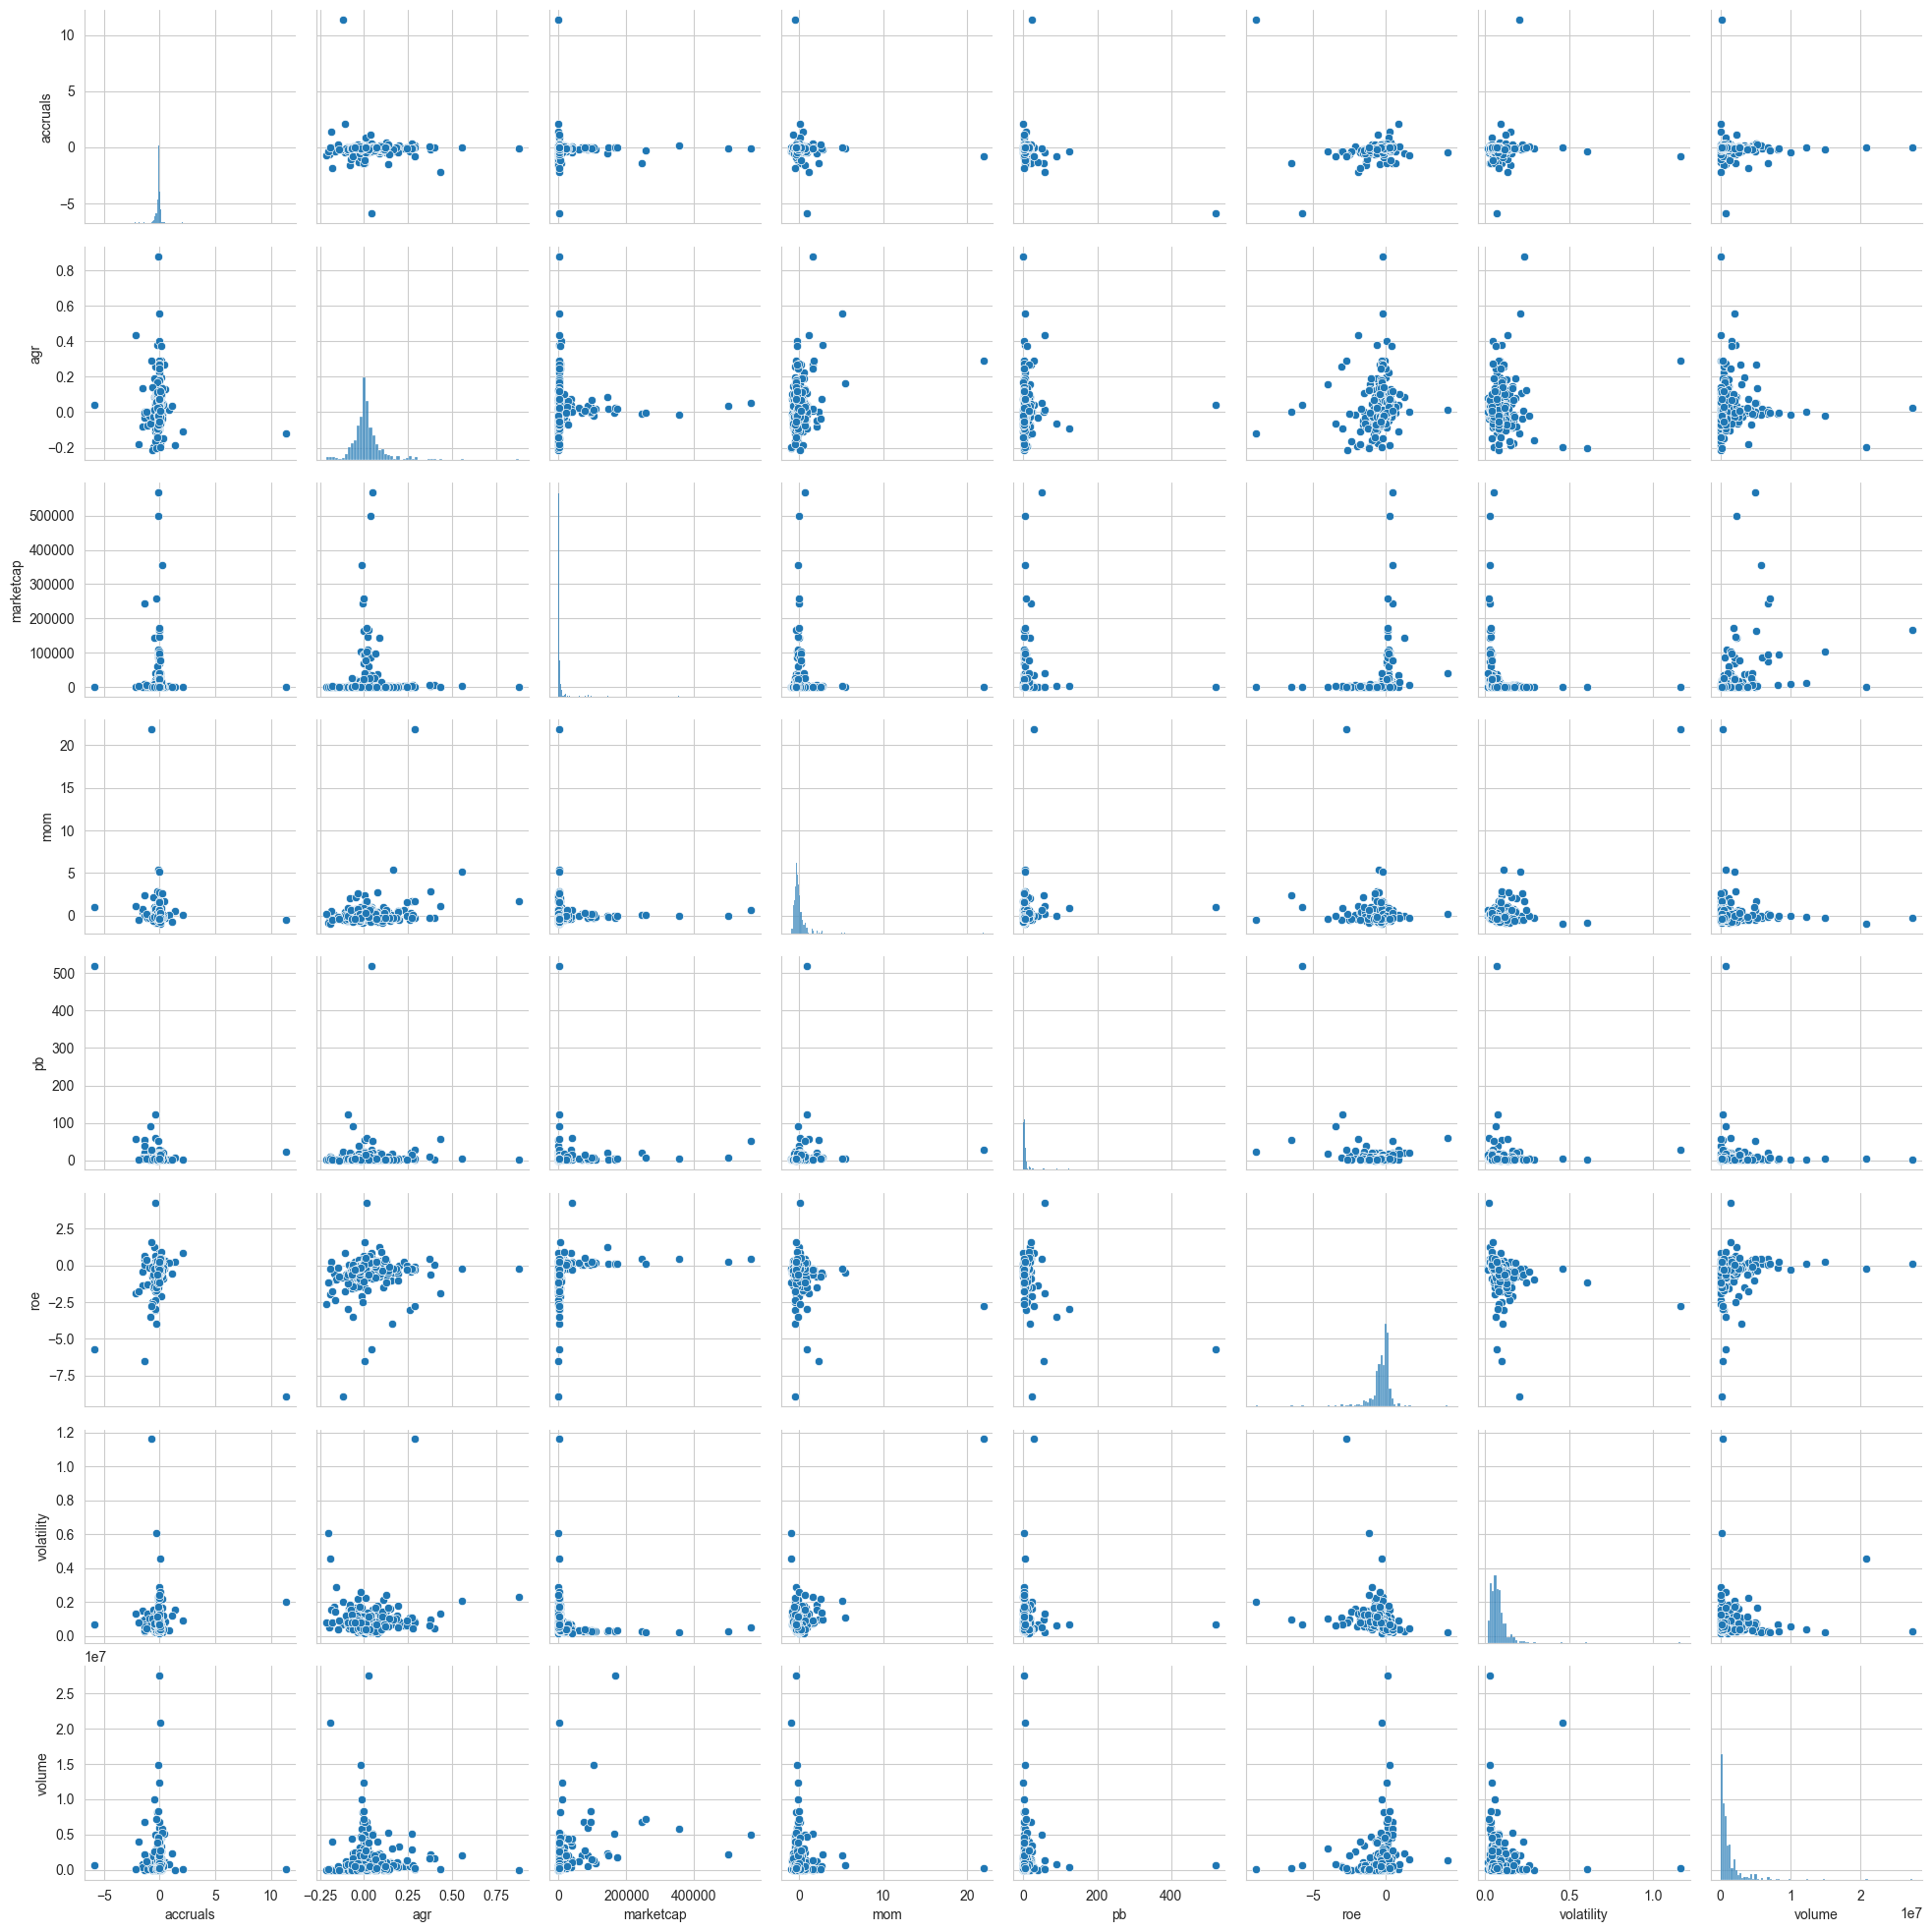

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

sns.pairplot(present[features])

### Calculate medians to use as base values for characteristics

In [33]:
present = future[future.date==future.date.max()]
medians = present[features].median()
medians = pd.DataFrame(medians).T

### Define plotting functions

In [51]:
def predict1(char):
    data = medians.copy()
    grid = np.linspace(
        present[char].quantile(0.01), 
        present[char].quantile(0.99), 
        100
    )
    predictions = []
    for x in grid:
        data[char] = x
        prediction = forest.predict(X=data).item()
        predictions.append(prediction)
    return grid, predictions

In [52]:
def predict2(char1, char2):
    data = medians.copy()
    grid1 = np.linspace(
        present[char1].quantile(0.01), 
        present[char1].quantile(0.99), 
        20
    )
    grid2 = np.linspace(
        present[char2].quantile(0.01), 
        present[char2].quantile(0.99), 
        20
    )
    grid1, grid2 = np.meshgrid(grid1, grid2)
    predictions = np.empty(grid1.shape)
    for i in range(20):
        for j in range(20):
            data[char1] = grid1[i, j]
            data[char2] = grid2[i, j]
            predictions[i, j] = forest.predict(data)
    return grid1, grid2, predictions

### Feature importances

In [44]:
importances = pd.Series(forest.feature_importances_, index=features)
importances.sort_values(ascending=False).round(3)

pb            0.464
volume        0.134
marketcap     0.115
agr           0.082
volatility    0.068
mom           0.064
accruals      0.047
roe           0.027
dtype: float64

### Vary one characteristic at a time and plot

- Specify which characteristic

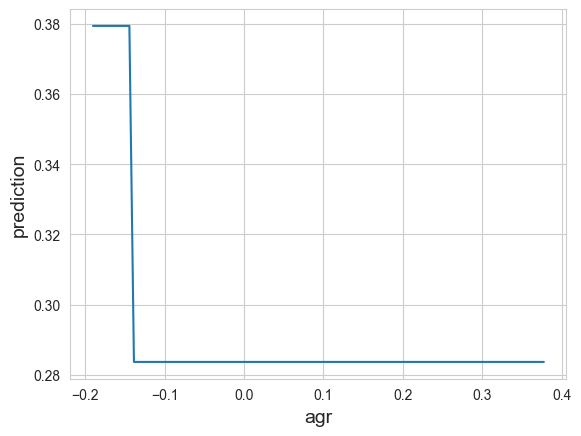

In [53]:
char = "agr"

grid, predictions = predict1(char)
plt.plot(grid, predictions)
plt.xlabel(char,  fontdict={"size": 14})
plt.ylabel("prediction",  fontdict={"size": 14})
plt.show()

### Vary two characteristics at a time and plot

- Specify which characteristics

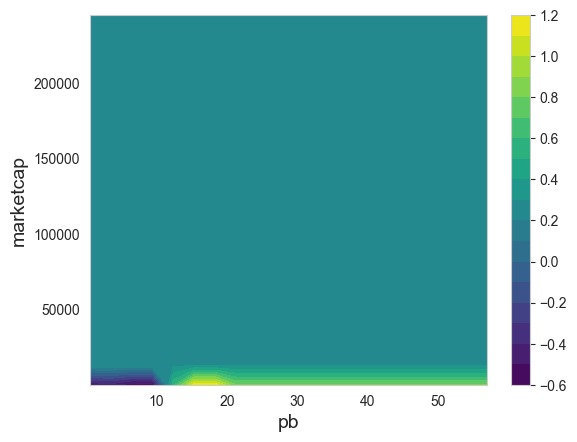

In [54]:
char1 = "pb"  
char2 = "marketcap"  

grid1, grid2, predictions = predict2(char1, char2)
contour = plt.contourf(grid1, grid2, predictions, 20, cmap="viridis")
cbar = plt.colorbar(contour)
plt.xlabel(char1, fontdict={"size": 14})
plt.ylabel(char2, fontdict={"size": 14})
plt.show()